In [30]:
%matplotlib inline

import os
import csv
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import sklearn as sk
from sklearn.cluster import KMeans
from sklearn.metrics import jaccard_similarity_score as jcs
from scipy.sparse import csr_matrix
from sklearn.metrics import roc_curve, auc

In [3]:
data = pd.read_csv('csv_export/funding_rounds.csv')
print (data.head(n=5))
print (len(data))

                company_name country_code state_code   region     city  \
0          Undercover Colors          USA         NC  Raleigh  Raleigh   
1                Agency Core          GBR        NaN   London   London   
2                     Algama          FRA        NaN    Paris    Paris   
3                     Bayzat          ARE        NaN    Dubai    Dubai   
4  Blackmoon Financial Group          RUS        NaN   Moscow   Moscow   

                               company_category_list funding_round_type  \
0                Fashion|Lifestyle|Social Innovation            venture   
1    Business Intelligence|Cloud Computing|Real Time            venture   
2  Biotechnology|Food and Beverage|Food Processin...            venture   
3  Banking|Employee Benefits|Insurance|Price Comp...            venture   
4                                            FinTech            venture   

  funding_round_code announced_on  raised_amount_usd  \
0                NaN   2016-11-11     5500000.00

In [4]:
data = data.drop('created_at', 1)
data = data.drop('updated_at', 1)
data = data.drop('cb_url', 1)
data = data.drop('post_money_currency_code', 1)
data = data.drop('post_money_valuation_usd', 1)
data = data.drop('post_money_valuation', 1)
data = data.drop('funding_round_type', 1)
data = data.drop('country_code', 1)
data = data.drop('state_code', 1)
data = data.drop('city', 1)
data = data.drop('funding_round_code', 1)
data = data.drop('announced_on', 1)
data = data.drop('raised_amount', 1)
data = data.drop('raised_amount_currency_code', 1)
data = data.drop('target_money_raised_usd', 1)
data = data.drop('target_money_raised', 1)
data = data.drop('target_money_raised_currency_code', 1)

print (data.head(n=5))

                company_name   region  \
0          Undercover Colors  Raleigh   
1                Agency Core   London   
2                     Algama    Paris   
3                     Bayzat    Dubai   
4  Blackmoon Financial Group   Moscow   

                               company_category_list  raised_amount_usd  \
0                Fashion|Lifestyle|Social Innovation     5500000.000000   
1    Business Intelligence|Cloud Computing|Real Time                NaN   
2  Biotechnology|Food and Beverage|Food Processin...     3842564.637427   
3  Banking|Employee Benefits|Insurance|Price Comp...     3500000.000000   
4                                            FinTech     2500000.000000   

   investor_count                            investor_names  \
0               0                                       NaN   
1               2      Scottish Investment Bank, Par Equity   
2               1                  Lead - Horizons Ventures   
3               1                       Lead - BEC

In [5]:
data = data[pd.notnull(data['raised_amount_usd'])]
datafinal = data[pd.notnull(data['investor_names'])]
print (datafinal.head(n=5))
print (len(datafinal))

                company_name       region  \
2                     Algama        Paris   
3                     Bayzat        Dubai   
4  Blackmoon Financial Group       Moscow   
5             Cape Analytics  SF Bay Area   
7                     Crayon       Boston   

                               company_category_list  raised_amount_usd  \
2  Biotechnology|Food and Beverage|Food Processin...     3842564.637427   
3  Banking|Employee Benefits|Insurance|Price Comp...     3500000.000000   
4                                            FinTech     2500000.000000   
5                             Information Technology    14000000.000000   
7                          Marketing|SaaS|Web Design     3350000.000000   

   investor_count                                     investor_names  \
2               1                           Lead - Horizons Ventures   
3               1                                Lead - BECO Capital   
4               3           Target Global, A&NN Group, Flint C

In [6]:
g = nx.DiGraph()

for index in range(0, len(datafinal)):
    node_to = str(datafinal.iloc[index]['company_name'])
    # there is only one investor
    if (datafinal.iloc[index]['investor_count'] == 1):
        node_from = str(datafinal.iloc[index]['investor_names'])
        if (node_from.find('Lead - ') != -1):
            node_from = node_from[node_from.find('Lead - ')+7:]
        edge_weight = datafinal.iloc[index]['raised_amount_usd']
        g.add_weighted_edges_from([(node_from, node_to, edge_weight)])
    
    # there are multiple investors
    else:
        inv_count = datafinal.iloc[index]['investor_count']
        # with one lead investor
        if (datafinal.iloc[index]['investor_names'].find('Lead - ') != -1):
            node_from = str(datafinal.iloc[index]['investor_names'])
            lead_inv = node_from[node_from.find('Lead - ')+7:node_from.find(',')]
            edge_weight_lead = (datafinal.iloc[index]['raised_amount_usd'])/3
            g.add_weighted_edges_from([(lead_inv, node_to, edge_weight_lead)])
            invs = node_from[node_from.find(', ')+2:]
            edge_weight = (datafinal.iloc[index]['raised_amount_usd'])*2/3/(inv_count-1)
            for inv in range(0, inv_count-2):
                node_from = invs[:invs.find(',')]
                g.add_weighted_edges_from([(node_from, node_to, edge_weight)])
                invs = invs[invs.find(', ')+2:]
            #don't forget last one
            g.add_weighted_edges_from([(invs, node_to, edge_weight)])
        # with no lead investor
        else:
            invs = str(datafinal.iloc[index]['investor_names'])
            edge_weight = (datafinal.iloc[index]['raised_amount_usd'])/(inv_count)
            for inv in range(0, inv_count-1):
                node_from = invs[:invs.find(',')]
                g.add_weighted_edges_from([(node_from, node_to, edge_weight)])
                invs = invs[invs.find(', ')+2:]
            g.add_weighted_edges_from([(invs, node_to, edge_weight)])
    # attributes for company
    g.node[node_to]['region'] = datafinal.iloc[index]['region']
    cat = str(datafinal.iloc[index]['company_category_list'])
    if (cat.find('|') != -1):
        cat = cat[:cat.find('|')]
    g.node[node_to]['cat'] = cat
    g.node[node_to]['uuid'] = datafinal.iloc[index]['company_uuid']

In [7]:
g.nodes(data=True)

[('Event Farm',
  {'cat': 'Brand Marketing',
   'region': 'Washington, D.C.',
   'uuid': 'f64708d6-230d-1472-152b-15ab73a6be52'}),
 ('', {}),
 ('Vivian Vendeirinho', {}),
 ('PATHSENSORS',
  {'cat': 'Biotechnology',
   'region': 'Baltimore',
   'uuid': 'b64f01ad-240b-ff4f-2d32-2d6af0997110'}),
 ('Rob Greyber', {}),
 ('Adam Felesky', {}),
 ('Lead Angels Network', {}),
 ('Razorback Capital', {}),
 ('SupplyStream',
  {'cat': 'Logistics',
   'region': 'Chicago',
   'uuid': '4037ce71-fef1-5aff-74d2-a1af2bdd2b6b'}),
 ('DuraFizz',
  {'cat': 'Biotechnology',
   'region': 'Boston',
   'uuid': 'e0e020fb-3ccc-caeb-e5f0-977400591852'}),
 ('Sudinnova', {}),
 ('LAMP Group',
  {'cat': 'Health Care',
   'region': 'Haywards Heath',
   'uuid': 'baf876a6-9402-8c55-fa5c-dd4bf18bf11e'}),
 ('KapNord', {}),
 ('Per-Olof Söderberg', {}),
 ('Conformia Software',
  {'cat': 'Knowledge Management',
   'region': 'SF Bay Area',
   'uuid': 'c7935699-c236-af92-df26-87d9af802bcd'}),
 ('Papaya Ventures (Accelerator)', {}

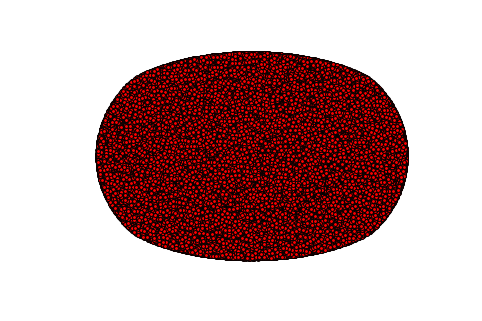

In [36]:
nx.draw(g, node_size=15)

In [8]:
g.edges(data=True)

[('', 'Tuned Global', {'weight': 5100000.0}),
 ('Vivian Vendeirinho',
  'RVE.SOL - Solucoes de Energia Rural',
  {'weight': 76656.166666666672}),
 ('Rob Greyber', 'Kitchenbowl', {'weight': 142857.14285714287}),
 ('Rob Greyber', 'TurnKey Vacation Rentals', {'weight': 230769.23076923078}),
 ('Adam Felesky', 'Borrowell', {'weight': 1066666.6666666667}),
 ('Lead Angels Network', 'Belita', {'weight': 83333.333333333328}),
 ('Lead Angels Network', 'Planet SuperHeroes', {'weight': 179897.0}),
 ('Razorback Capital', 'Leap.it', {'weight': 190000.0}),
 ('Razorback Capital', 'SignalSet', {'weight': 1333333.3333333333}),
 ('Sudinnova', 'Interview', {'weight': 330000.0}),
 ('Sudinnova', 'Lucibel', {'weight': 977079.5}),
 ('Sudinnova', 'Polyplus-transfection', {'weight': 1079000.0}),
 ('Sudinnova', 'Groupe Adeuza', {'weight': 455000.0}),
 ('Sudinnova', 'TLM Com', {'weight': 615000.0}),
 ('KapNord', 'Crestock', {'weight': 300000.0}),
 ('Per-Olof Söderberg', 'Attivio', {'weight': 6200000.0}),
 ('Papay

In [9]:
gr = nx.Graph(g)

In [10]:
a = nx.adjacency_matrix(gr)
print (a)

  (0, 22914)	2600000.0
  (0, 56521)	6100000.0
  (1, 77865)	5100000.0
  (2, 73472)	76656.1666667
  (3, 21838)	1755000.0
  (3, 64217)	500000.0
  (4, 44601)	142857.142857
  (4, 70965)	230769.230769
  (5, 16016)	1066666.66667
  (6, 1189)	83333.3333333
  (6, 68461)	179897.0
  (7, 12619)	190000.0
  (7, 43327)	1333333.33333
  (8, 23705)	528885.0
  (9, 53856)	5097136.86541
  (10, 34764)	6200000.0
  (11, 12062)	60000000.0
  (12, 72330)	555555.555556
  (13, 238)	1500000.0
  (13, 29986)	3300000.0
  (13, 44701)	5233333.33333
  (13, 45740)	3300000.0
  (13, 70051)	5233333.33333
  (14, 62080)	9250000.0
  (15, 1144)	2666666.66667
  :	:
  (83139, 60206)	10000000.0
  (83139, 82103)	10666666.6667
  (83140, 34449)	2233333.33333
  (83140, 37063)	9650367.0
  (83141, 61633)	125000.0
  (83142, 507)	1316666.66667
  (83142, 34398)	1750000.0
  (83142, 78694)	658333.333333
  (83143, 19971)	200000.0
  (83144, 77758)	5128205.12821
  (83145, 78128)	2333333.33333
  (83146, 51262)	59000.0
  (83146, 76385)	59000.0
  (8

In [11]:
kmeans = KMeans(n_clusters=100, random_state=0).fit(a)
kmeans.labels_

array([8, 8, 8, ..., 8, 8, 8], dtype=int32)

In [12]:
kmeans.cluster_centers_

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

# Supervised Learning

In [13]:
# get categorized companies only
print (len(datafinal))
data_wcats = datafinal[pd.notnull(datafinal['company_category_list'])]
print (len(data_wcats))
print (type(data_wcats))
data_wcats = np.array(data_wcats)
print (type(data_wcats))

75398
74339
<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>


In [14]:
idx = np.random.choice(data_wcats.shape[0], size=66905, replace=False)
print (idx)
print (len(idx))
tr = data_wcats[idx,:]
print (tr)
print (len(tr))

tr = pd.DataFrame(tr, columns=['company_name','region','company_category_list','raised_amount_usd','investor_count','investor_names','company_uuid','funding_round_uuid'])
print (tr.head(n=5))

[69921 33182 58938 ..., 38559 31585  4759]
66905
[['Megisto Systems' 'Washington, D.C.'
  'Delivery|Mobile|Subscription Service' ...,
  'Lead - Norwest Venture Partners - NVP'
  '11e3deb6-5c07-f504-2bf4-10628a694b29'
  'afd58f18-9a39-727d-09bb-ef4dc106e35d']
 ['Pwnie Express' 'Boston' 'Cyber Security|Network Security|Software' ...,
  'Lead - Fairhaven Capital Partners, Lead - .406 Ventures, Vermont Seed Capital Fund'
  '24381d38-ac8f-fa36-473f-decd4d77aded'
  '7f1310de-6773-4f36-d797-07fe4a79d9a3']
 ['Conduit' 'Tel Aviv' 'Cloud Computing|Internet|Software' ...,
  'Lead - Benchmark' '79b4f29d-d7af-1f6e-d6d5-5b45952aa654'
  '12faf414-1f1e-b507-0b8b-7a0bc1ce154b']
 ..., 
 ['PictureHealing' 'Los Angeles' 'Charity|Humanitarian|Mobile|Non Profit'
  ..., 'Jared Sheehan, Tammy Brandt' '652cbe7b-65b0-38b7-ea7b-e564e4d9ce25'
  '72793e6a-7796-92fc-b5b6-ec26bac204e4']
 ['Neurotrack' 'SF Bay Area'
  'Biotechnology|Health Care|Health Diagnostics|Information Technology'
  ..., 'Lead - Social Capital,

In [15]:
tr_g = nx.DiGraph()

for index in range(0, len(tr)):
    node_to = str(tr.iloc[index]['company_name'])
    # there is only one investor
    if (tr.iloc[index]['investor_count'] == 1):
        node_from = str(tr.iloc[index]['investor_names'])
        if (node_from.find('Lead - ') != -1):
            node_from = node_from[node_from.find('Lead - ')+7:]
        edge_weight = tr.iloc[index]['raised_amount_usd']
        tr_g.add_weighted_edges_from([(node_from, node_to, edge_weight)])
    
    # there are multiple investors
    else:
        inv_count = tr.iloc[index]['investor_count']
        # with one lead investor
        if (tr.iloc[index]['investor_names'].find('Lead - ') != -1):
            node_from = str(tr.iloc[index]['investor_names'])
            lead_inv = node_from[node_from.find('Lead - ')+7:node_from.find(',')]
            edge_weight_lead = (tr.iloc[index]['raised_amount_usd'])/3
            tr_g.add_weighted_edges_from([(lead_inv, node_to, edge_weight_lead)])
            invs = node_from[node_from.find(', ')+2:]
            edge_weight = (tr.iloc[index]['raised_amount_usd'])*2/3/(inv_count-1)
            for inv in range(0, inv_count-2):
                node_from = invs[:invs.find(',')]
                tr_g.add_weighted_edges_from([(node_from, node_to, edge_weight)])
                invs = invs[invs.find(', ')+2:]
            #don't forget last one
            tr_g.add_weighted_edges_from([(invs, node_to, edge_weight)])
        # with no lead investor
        else:
            invs = str(tr.iloc[index]['investor_names'])
            edge_weight = (tr.iloc[index]['raised_amount_usd'])/(inv_count)
            for inv in range(0, inv_count-1):
                node_from = invs[:invs.find(',')]
                tr_g.add_weighted_edges_from([(node_from, node_to, edge_weight)])
                invs = invs[invs.find(', ')+2:]
            tr_g.add_weighted_edges_from([(invs, node_to, edge_weight)])
    # attributes for company
    tr_g.node[node_to]['region'] = tr.iloc[index]['region']
    cat = str(tr.iloc[index]['company_category_list'])
    if (cat.find('|') != -1):
        cat = cat[:cat.find('|')]
    tr_g.node[node_to]['cat'] = cat
    tr_g.node[node_to]['uuid'] = tr.iloc[index]['company_uuid']

In [16]:
tr_gr = nx.Graph(tr_g)
tr_a = nx.adjacency_matrix(tr_gr)
print (tr_a)

  (0, 52244)	6100000.0
  (1, 71812)	5100000.0
  (2, 6602)	76656.1666667
  (3, 8778)	500000.0
  (3, 20273)	1755000.0
  (4, 45734)	142857.142857
  (4, 65479)	230769.230769
  (5, 40002)	1066666.66667
  (6, 3925)	12750000.0
  (7, 3768)	190000.0
  (7, 40175)	1333333.33333
  (8, 16079)	1000000.0
  (9, 2985)	1079000.0
  (9, 5505)	977079.5
  (9, 55333)	330000.0
  (10, 49781)	5097136.86541
  (11, 32291)	12000000.0
  (12, 11157)	60000000.0
  (13, 211)	1500000.0
  (13, 4552)	3300000.0
  (13, 41394)	5233333.33333
  (13, 42335)	3300000.0
  (13, 55538)	5233333.33333
  (14, 57348)	9250000.0
  (15, 13715)	19811788.0139
  :	:
  (76625, 10085)	450000.0
  (76625, 68803)	533333.333333
  (76625, 74870)	533333.333333
  (76626, 31990)	2222222.22222
  (76626, 34377)	9650367.0
  (76627, 34344)	125000.0
  (76628, 461)	1316666.66667
  (76628, 72583)	658333.333333
  (76629, 18521)	200000.0
  (76630, 11652)	2800000.0
  (76631, 4296)	333333.333333
  (76631, 34188)	333333.333333
  (76631, 60930)	333333.333333
  (766

In [17]:
te = np.delete(data_wcats, idx, 0)
print (te)
print (len(te))

te = pd.DataFrame(te, columns=['company_name','region','company_category_list','raised_amount_usd','investor_count','investor_names','company_uuid','funding_round_uuid'])
print (te.head(n=5))

[['Algama' 'Paris'
  'Biotechnology|Food and Beverage|Food Processing|Life Science' ...,
  'Lead - Horizons Ventures' '12da7eda-8dda-1e74-0bb1-184b05a0a33b'
  '173a39ef-b3d3-290a-fa5c-2b6a5d00ff5b']
 ['Crayon' 'Boston' 'Marketing|SaaS|Web Design' ...,
  'BoxGroup, Eric Paley, Converge Venture Partners, Steve Anderson'
  'cd0da7f6-c6d8-eac6-ea11-3d18005f38ab'
  'ba6d58d3-e3fc-0374-2c6c-3d20071059f9']
 ['Intuity Medical' 'SF Bay Area' 'Diabetes|Health Care|Medical' ...,
  'Lead - PTV Healthcare Capital, Investor Growth Capital, Accuitive Medical Ventures, Luther King Capital Management, Versant Ventures, U.S. Venture Partners (USVP), Venrock'
  '4784b32a-ab2d-fc31-46cc-7fe360fce48e'
  'c75436f9-fdc7-2fb8-4485-e901fb05c33e']
 ..., 
 ['Digitel' 'BRA - Other'
  'Big Data|Data Visualization|Information Technology' ...,
  'CRP Companhia de Participações' 'a9974969-5a5b-a5c4-c658-cc4007078dd2'
  'e1c2d371-e6e1-cf08-7bfe-bcf6a24ec5b0']
 ['Electronic Arts' 'SF Bay Area' 'Computer|Video Games|W

In [18]:
te_g = nx.DiGraph()

for index in range(0, len(te)):
    node_to = str(te.iloc[index]['company_name'])
    # there is only one investor
    if (te.iloc[index]['investor_count'] == 1):
        node_from = str(te.iloc[index]['investor_names'])
        if (node_from.find('Lead - ') != -1):
            node_from = node_from[node_from.find('Lead - ')+7:]
        edge_weight = te.iloc[index]['raised_amount_usd']
        te_g.add_weighted_edges_from([(node_from, node_to, edge_weight)])
    
    # there are multiple investors
    else:
        inv_count = te.iloc[index]['investor_count']
        # with one lead investor
        if (te.iloc[index]['investor_names'].find('Lead - ') != -1):
            node_from = str(te.iloc[index]['investor_names'])
            lead_inv = node_from[node_from.find('Lead - ')+7:node_from.find(',')]
            edge_weight_lead = (te.iloc[index]['raised_amount_usd'])/3
            te_g.add_weighted_edges_from([(lead_inv, node_to, edge_weight_lead)])
            invs = node_from[node_from.find(', ')+2:]
            edge_weight = (te.iloc[index]['raised_amount_usd'])*2/3/(inv_count-1)
            for inv in range(0, inv_count-2):
                node_from = invs[:invs.find(',')]
                te_g.add_weighted_edges_from([(node_from, node_to, edge_weight)])
                invs = invs[invs.find(', ')+2:]
            #don't forget last one
            te_g.add_weighted_edges_from([(invs, node_to, edge_weight)])
        # with no lead investor
        else:
            invs = str(te.iloc[index]['investor_names'])
            edge_weight = (te.iloc[index]['raised_amount_usd'])/(inv_count)
            for inv in range(0, inv_count-1):
                node_from = invs[:invs.find(',')]
                te_g.add_weighted_edges_from([(node_from, node_to, edge_weight)])
                invs = invs[invs.find(', ')+2:]
            te_g.add_weighted_edges_from([(invs, node_to, edge_weight)])
    # attributes for company
    te_g.node[node_to]['region'] = te.iloc[index]['region']
    cat = str(te.iloc[index]['company_category_list'])
    if (cat.find('|') != -1):
        cat = cat[:cat.find('|')]
    te_g.node[node_to]['cat'] = cat
    te_g.node[node_to]['uuid'] = te.iloc[index]['company_uuid']

In [19]:
te_gr = nx.Graph(te_g)
te_a = nx.adjacency_matrix(te_gr)
print (te_a)

  (0, 8660)	2600000.0
  (1, 7805)	141666.666667
  (2, 4793)	145000.0
  (3, 14880)	5111111.11111
  (4, 3200)	711111.111111
  (5, 14648)	425000.0
  (6, 10947)	9311111.11111
  (7, 11326)	120000.0
  (8, 2178)	1362923.92613
  (8, 6713)	1362923.92613
  (8, 12915)	1362923.92613
  (8, 13313)	1362923.92613
  (8, 14172)	2725847.85226
  (9, 13069)	1000000.0
  (10, 3722)	2133333.33333
  (10, 7484)	2133333.33333
  (10, 11205)	620000.0
  (10, 12693)	620000.0
  (11, 2588)	566666.666667
  (11, 6503)	1133333.33333
  (12, 7729)	390000.0
  (13, 846)	83333.3333333
  (14, 142)	1515251.33333
  (14, 12958)	3030502.66667
  (15, 6938)	20000000.0
  :	:
  (15280, 11053)	5833333.33333
  (15280, 12421)	989667.5
  (15280, 13756)	1150000.0
  (15280, 14870)	1500000.0
  (15281, 6430)	100000.0
  (15282, 10989)	2142857.14286
  (15283, 13945)	40090.9090909
  (15284, 4545)	142857.142857
  (15284, 6543)	60000.0
  (15285, 9296)	1750000.0
  (15286, 909)	714285.714286
  (15287, 11414)	5128205.12821
  (15288, 1401)	1666666.666

In [20]:
# get uncategorized comapnies -- to predict
data_uncats = datafinal[pd.isnull(datafinal['company_category_list'])]
print (data_uncats.head(n=5))
print (len(data_uncats))

    company_name       region company_category_list  raised_amount_usd  \
13      HerdDogg       Denver                   NaN      750000.000000   
22     LetsCargo          NaN                   NaN      700000.000000   
38  Total Trivia  Minneapolis                   NaN     2500000.000000   
44     EZParking     Shanghai                   NaN    13278292.352589   
50   iimjobs.com          NaN                   NaN     2000000.000000   

    investor_count                                     investor_names  \
13               1                                     Serra Ventures   
22               1                   Lead - Global from Day One - GD1   
38               1                           Trifecta Retail Ventures   
44               1                         Lead - ZJAMP Holding Group   
50               3  Lead - India Quotient, Calcutta Angels, Tracxn...   

                            company_uuid                    funding_round_uuid  
13  446177ee-0a00-1821-7fa7-9f99c60

### Link Prediction: Jacard Similarity Function

In [21]:
te_edges = te_g.edges(data=True)

out = open('te_data.csv', 'w')
out.write('investor\tcompany\tvalue\n')
for index in range(0, len(te_edges)):
    curr_item = te_edges.pop()
    out.write(curr_item[0] + '\t' + curr_item[1] + '\t' + str(curr_item[2]['weight']) + '\n')
out.close()

In [22]:
te_data = pd.read_csv('te_data.csv', sep='\t')
print (te_data.head(n=5))

         investor                company           value
0  Wipro Ventures        Vectra Networks  8700000.000000
1     David Chang                 InMoji  1500000.000000
2     David Chang               Renoviso    93333.333333
3      123Venture     Tetco Technologies  1293333.333333
4      123Venture  Cooltech Applications   643300.000000


In [57]:
jsim_scores = []

investors = np.array(te_data['investor'])
companies = np.array(te_data['company'])

for index in range(0, len(te_data)):
    inv = investors[index]
    comp = companies[index]
    inv_neighbors = np.array(te_gr.neighbors(inv))
    neighbors = []
    for j in range(0, len(inv_neighbors)):
        neighbors.append(np.array(te_gr.neighbors(inv_neighbors[j])))
    comp_neighbors = np.array(te_gr.neighbors(comp))
    neighbors = (np.array(neighbors)).ravel()
    
    comp_neighbors = list(comp_neighbors)
    neighbors = list(neighbors)
    
    print (type(comp_neighbors))
    
    intersection = set(comp_neighbors).intersection(neighbors)
    
    
    #intersection = np.intersect1d(neighbors, comp_neighbors)
    union = np.union1d(neighbors, comp_neighbors)
    jsim_score = ((float)(len(intersection)))/(len(union))
    jsim_scores.append(jsim_score)
max_score = max(jsim_scores)

print (jsim_scores)


# pred = jsim_scores
# label = pd.notnull(te_data['value'])
# fpr, tpr, thresholds = roc_curve(label, pred)
# roc_auc = auc(fpr, tpr)
# print ("Area under the ROC curve : %f" % roc_auc)
# matplotlib.rcParams['figure.figsize'] = (10, 10)
# plt.plot(fpr, tpr, color='magenta', label='ROC curve (area = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], 'k--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Jaccard Similarity Measure ROC')
# plt.legend(loc="lower right")
# plt.show()

<class 'list'>
<class 'list'>


TypeError: unhashable type: 'numpy.ndarray'